In [72]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from random import seed
keras = tf.keras
execfile("./windowgenerator.py")
execfile("./tf_models.py")

DATA_PATHS = [
  # "data/mpi_saale_2023b.csv",
  "data/mpi_roof_2023b.csv", "data/mpi_roof_2023a.csv", "data/mpi_roof_2022b.csv", "data/mpi_roof_2022a.csv",
  "data/mpi_roof_2021b.csv", "data/mpi_roof_2021a.csv", "data/mpi_roof_2020b.csv", "data/mpi_roof_2020a.csv",
]
MAX_EPOCHS = 20
OUT_STEPS = 24
FEATURES = ['rain (mm)']
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(1224)

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

                  count         mean         std          min          25%  \
p (mbar)         4416.0   995.842251    9.325911   961.900000   990.275000   
T (degC)         4416.0    13.265593    7.937319    -5.860000     8.185000   
rh (%)           4416.0    80.881766   18.968881    22.620000    69.595000   
sh (g/kg)        4416.0     7.908469    2.906081     2.390000     5.610000   
Tpot (K)         4416.0   286.759103    7.887126   267.650000   281.730000   
Tdew (degC)      4416.0     9.427736    5.753104    -6.210000     5.300000   
VPmax (mbar)     4416.0    17.146320    9.208467     3.940000    10.875000   
VPact (mbar)     4416.0    12.598363    4.627185     3.840000     8.917500   
VPdef (mbar)     4416.0     4.547966    6.783290     0.000000     0.060000   
H2OC (mmol/mol)  4416.0    12.645695    4.623982     3.840000     8.990000   
rho (g/m**3)     4416.0  1206.360765   35.659840  1114.050000  1180.940000   
rain (mm)        4416.0     0.014518    0.106881     0.000000   

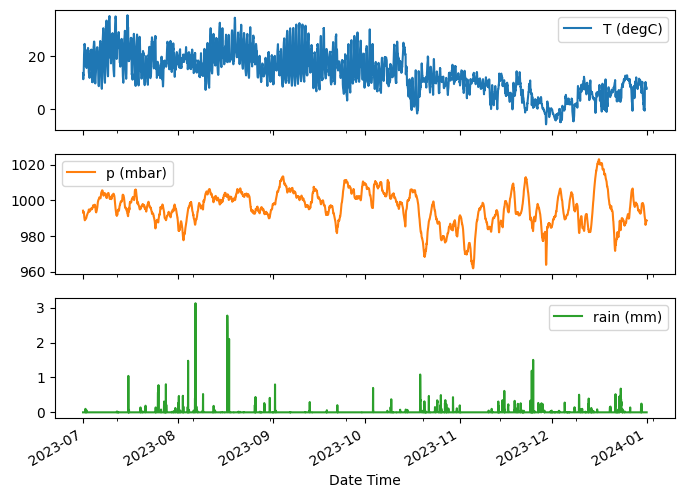

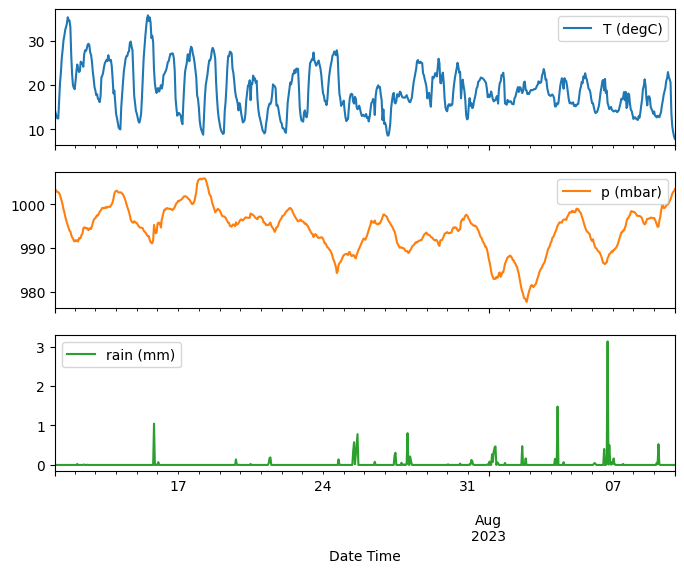

In [73]:
# Data instantiation and analysis
csvs = (pd.read_csv(f, encoding='ansi') for f in DATA_PATHS)
df = pd.concat(csvs, ignore_index=True)

df = df[5::6] # Slice down to every 6th record (every hour) starting from index 5 to configure for hourly predictions
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Feature engineering
# Combine wind velocity and direction scalars into a vector for ease of processing
wv = df.pop('wv (m/s)')
wd_rad = df.pop('wd (deg)') * np.pi / 180

df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Day frequency values
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

print(df.describe().transpose())

# Data split
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
df_train = df[0:int(0.7 * n)]
df_valid = df[int(0.7 * n):int(0.9 * n)]
df_test = df[int(0.9 * n):]
num_features = df.shape[1]

plot_cols = ["T (degC)", "p (mbar)", "rain (mm)"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][240:960]
plot_features.index = date_time[240:960]
_ = plot_features.plot(subplots=True)


C:\Users\Harrison\AppData\Local\Temp\ipykernel_6472\4006364998.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


                  count          mean  std       min       25%       50%  \
p (mbar)         3091.0  4.022807e-15  1.0 -3.837403 -0.463774  0.135230   
T (degC)         3091.0  1.103399e-16  1.0 -2.879321 -0.758839 -0.098718   
rh (%)           3091.0  2.022897e-16  1.0 -2.661165 -0.701018  0.218083   
sh (g/kg)        3091.0  1.103399e-16  1.0 -2.467776 -0.701218 -0.122157   
Tpot (K)         3091.0  2.574597e-16  1.0 -2.966321 -0.706618 -0.102196   
Tdew (degC)      3091.0 -1.103399e-16  1.0 -3.556843 -0.647284  0.000696   
VPmax (mbar)     3091.0 -2.942396e-16  1.0 -1.708506 -0.746694 -0.249477   
VPact (mbar)     3091.0 -7.355991e-17  1.0 -2.456030 -0.696749 -0.112078   
VPdef (mbar)     3091.0  3.677995e-17  1.0 -0.762275 -0.762275 -0.389082   
H2OC (mmol/mol)  3091.0 -4.045795e-16  1.0 -2.478643 -0.703434 -0.119623   
rho (g/m**3)     3091.0  1.360858e-15  1.0 -2.761523 -0.681489 -0.011387   
rain (mm)        3091.0 -1.838998e-17  1.0 -0.112988 -0.112988 -0.112988   
SWDR (W/m**2

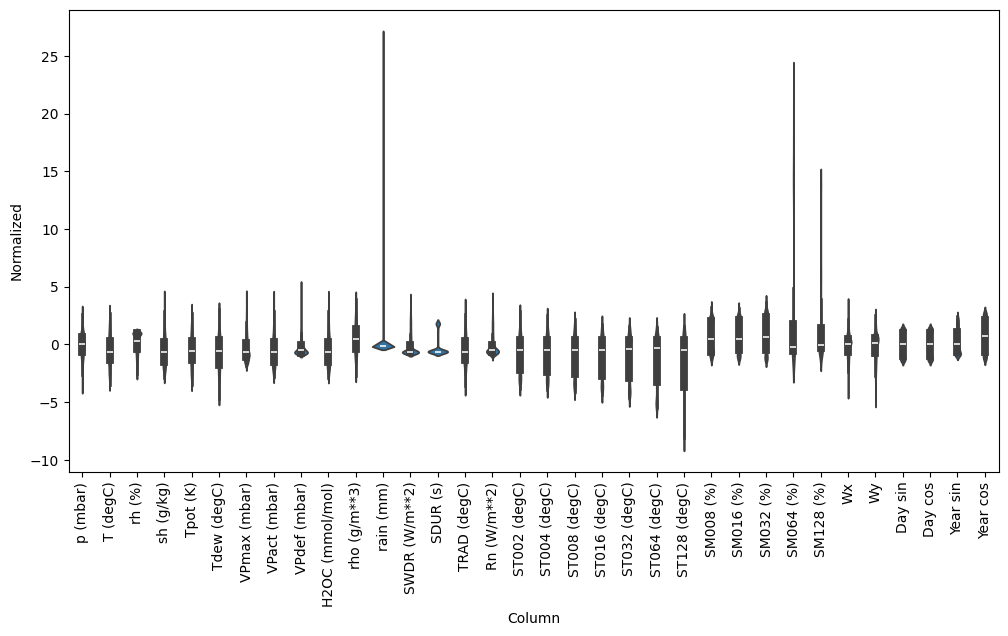

In [74]:
# Normalization
mean = df_train.mean()
std = df_train.std()
df_train = (df_train - mean) / std
df_valid = (df_valid - mean) / std
df_test = (df_test - mean) / std

df_std = (df - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(df_train.describe().transpose())

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['rain (mm)']


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0614 - mean_absolute_error: 0.2088 - val_loss: 0.5767 - val_mean_absolute_error: 0.1938
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0403 - mean_absolute_error: 0.1966 - val_loss: 0.5792 - val_mean_absolute_error: 0.1916
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0420 - mean_absolute_error: 0.1951 - val_loss: 0.5748 - val_mean_absolute_error: 0.2042
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0146 - mean_absolute_error: 0.1980 - val_loss: 0.5760 - val_mean_absolute_error: 0.1999
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9151 - mean_absolute_error: 0.1986 - val_loss: 0.5757 - val_mean_absolute_error: 0.1973
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5707 - mean_absolute_error: 0.1914
Validation performance: {'loss': 0.5757403373718262, 'mean_absolute_error': 0.19732949137687683}
Test performance: {'loss': 0.4294694662094116, 'mean_absolute_error': 0.2043032

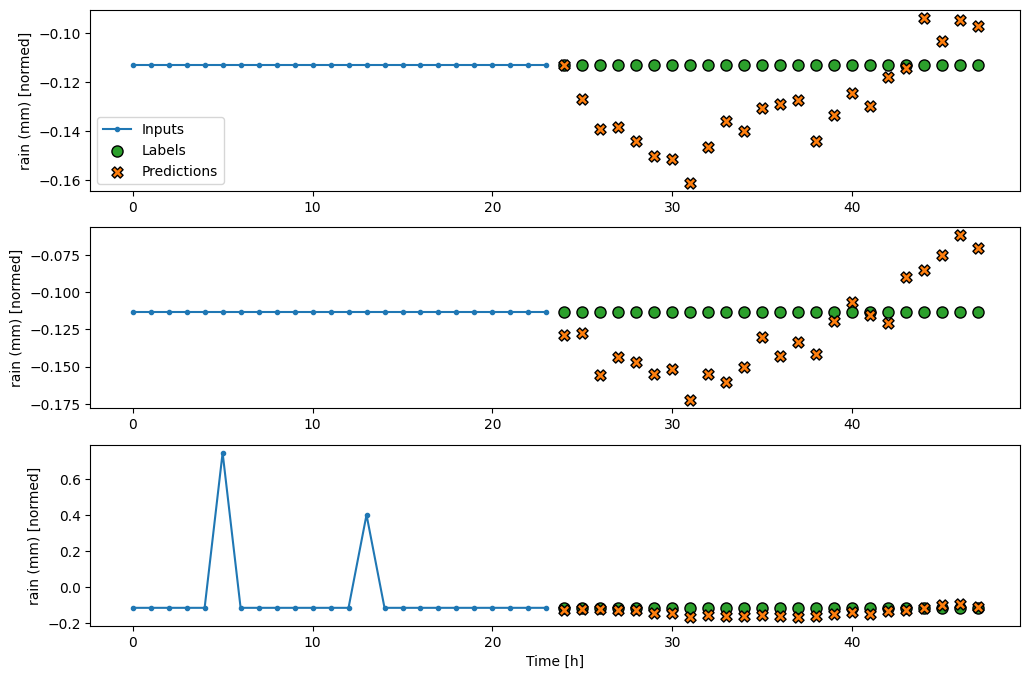

In [75]:
# Model initialization and training

window = WindowGenerator(
    input_width=24, label_width=24, shift=OUT_STEPS,
    label_columns = FEATURES,
    train_df=df_train, val_df=df_valid, test_df=df_test
)
print(window)

model = keras.Sequential([
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

model.summary()
compile_and_fit(model, window)

val_performance = model.evaluate(window.val, return_dict=True)
performance = model.evaluate(window.test, verbose=0, return_dict=True)


print("Validation performance:", val_performance)
print("Test performance:", performance)

for f in FEATURES:
    window.plot(model, f)

In [189]:
# Run to save the model's weights
model.save("./output/druid.keras")